In [1]:
# Import libraries
import numpy as np
import pandas as pd
import string
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# Input parameters
export_feedback_table = False
inputfile_sssummary  = 'output/studentsummary2_20240222.csv'
inputfile_assignment = 'rawdata/assignment_20240222.csv'
inputfile_feedback   = 'rawdata/feedback_20240222.csv'
outputfile_feedback  = 'output/feedback_pretest_20240222.xlsx'

In [3]:
# Import raw data and converting 'created' to datetime
df_sssummary  = pd.read_csv(inputfile_sssummary, index_col=0)
df_assignment = pd.read_csv(inputfile_assignment, index_col=0)
df_feedback   = pd.read_csv(inputfile_feedback, index_col=0)
df_sssummary['1st_created'] = pd.to_datetime(df_sssummary['1st_created'])
df_assignment['created']    = pd.to_datetime(df_assignment['created'])
df_feedback['created']      = pd.to_datetime(df_feedback['created'])

In [4]:
# Preview summary of students
df_sssummary

,anonym,1st_assignment_id,1st_instance_id,1st_created,1st_finished,2nd_assignment_id,2nd_instance_id,2nd_created,2nd_finished
0,AS23S0335,9cc8536e-35ac-4874-807d-9da3d47a4a89,SLF6A,2023-11-02 08:53:20.875,2023-11-02 09:25:30.675000,45209efe-cda7-480f-8984-1a3f780c840d,MYF6A,2023-12-14 07:11:24.502000,2023-12-14 07:34:11.516000
1,AS23S0336,773fac84-9653-4706-94f2-555506fc3c33,MLF6A,2023-11-02 08:58:00.657,2023-11-02 09:22:16.908000,d2fa8b28-d4d6-4c19-82aa-da16bd7a5788,SYF6A,2023-12-14 07:05:41.840000,2023-12-14 07:35:03.174000
2,AS23S0338,7bc2eab6-f284-42ae-b22b-5edfb37dbe8b,SPF6A,2023-11-02 08:54:09.316,2023-11-02 09:38:22.077000,af7ce587-f8ad-4459-93b0-57fd57d9f51a,MTF6A,2023-12-14 07:08:11.195000,2023-12-14 07:51:40.348000
3,AS23S0339,7448ecde-72d7-4a88-817f-ed4a726879b9,MPF6A,2023-11-02 08:58:04.547,2023-11-02 09:22:15.866000,10119783-d851-4169-a3cd-cd90e31b3c4d,SYF6A,2023-12-14 07:11:25.845000,2023-12-14 07:50:46.121000
4,AS23S0340,d47c0ae8-7835-460b-95fa-c7628e5b2a6f,SLF6A,2023-11-02 08:54:17.666,2023-11-02 09:38:28.370000,4ba95ff5-dce4-4fb3-9ede-5f8b1e85aaa3,MTF6A,2023-12-14 07:10:13.541000,2023-12-14 07:48:41.943000
...,...,...,...,...,...,...,...,...,...
164,KS23S7504,1daffd53-64f0-423f-a501-7aff26dd1de0,SLU5A,2023-11-03 07:28:42.896,2023-11-03 07:50:57.367000,NaN,NaN,NaN,NaN
165,KS23S7505,88363ab5-e685-47fb-a086-47298f636902,SLU5A,2023-11-03 07:29:29.346,NaN,NaN,NaN,NaN,NaN
166,KS23S7506,0041f35d-0cbd-4efe-82c4-b62a72aec1d4,MLU5A,2023-11-03 07:28:27.723,2023-11-03 08:00:36.275000,NaN,NaN,NaN,NaN
167,KS23S7507,43da8763-68ef-4ed9-8735-162eeceedf07,SPU5A,2023-11-03 07:28:50.540,2023-11-03 08:00:26.558000,NaN,NaN,NaN,NaN


### Feedback Data Preprocessing

In [5]:
# Add the 'time_elapsed' column to df_feedback

def calculate_time_difference(row, df_a):
    sid = row['assignment_id'] 
    action_time = row['created']
    # Check if student_id exists in df_a
    if sid in df_a.index:
        starting_time = df_a.at[sid, 'created']
        return (action_time - starting_time).total_seconds()
    else:
        return None  # or some other default value

df_feedback['time_elapsed'] = df_feedback.apply(lambda row: calculate_time_difference(row, df_assignment), axis=1)

In [18]:
# Sort the DataFrame by 'assignment_id' and 'created' to ensure the order
df_feedback = df_feedback.sort_values(by=['assignment_id', 'created'])

# Add a new column 'sequence' which enumerates each student's rows starting from 1
df_feedback['count'] = df_feedback.groupby('assignment_id').cumcount() + 1

In [19]:
# Use 911e7cad-2261-4755-825d-dd734c8bfaa1 for testing
# Find the starting time of the student
print(df_assignment.loc['911e7cad-2261-4755-825d-dd734c8bfaa1','created'])
df_feedback[df_feedback['assignment_id']=='911e7cad-2261-4755-825d-dd734c8bfaa1']
df_feedback[df_feedback['assignment_id']=='8fe8bdd5-1bfe-4c12-873b-810b4dc9de57']


2023-11-02 07:24:41.273000


,assignment_id,phase,type_id,feedback_text,details,created,time_elapsed,count
action_id,,,,,,,,
2ebbe296-d612-4bca-9cdf-73ca5c3087c9,8fe8bdd5-1bfe-4c12-873b-810b4dc9de57,snippet_micro,NaN,Pääkohtien valinnan tarkoituksena on löytää te...,"{""text_id"": 302, ""feedback_code"": 0, ""details""...",2023-11-03 08:28:28.429,256.887,1
a5b2ff07-e9ee-4e7a-b25b-3d580b1b9fce,8fe8bdd5-1bfe-4c12-873b-810b4dc9de57,snippet_micro,NaN,Erinomaista! Olet valinnut tästä tekstistä 4 p...,"{""text_id"": 302, ""feedback_code"": 9, ""details""...",2023-11-03 08:30:59.290,407.748,2
55217017-2e70-4c34-8e65-2a1716221582,8fe8bdd5-1bfe-4c12-873b-810b4dc9de57,snippet_micro,NaN,Mahtava yritys! Olet valinnut tästä tekstistä ...,"{""text_id"": 301, ""feedback_code"": 3, ""details""...",2023-11-03 08:36:43.661,752.119,3
63a09dac-1742-48a4-baaa-e30df3f5fafa,8fe8bdd5-1bfe-4c12-873b-810b4dc9de57,snippet_micro,NaN,Huikeaa! Olet valinnut tästä tekstistä 5 pääko...,"{""text_id"": 301, ""feedback_code"": 9, ""details""...",2023-11-03 08:37:19.568,788.026,4
57b62cf5-752b-4560-8360-65a2d2d5ea7c,8fe8bdd5-1bfe-4c12-873b-810b4dc9de57,snippet_micro,NaN,Hyvin menee! Olet valinnut 5 pääkohtaa tästä t...,"{""text_id"": 308, ""feedback_code"": 1, ""details""...",2023-11-03 08:43:01.230,1129.688,5
b886bfcd-5a0e-494d-9f36-369619e0d9fe,8fe8bdd5-1bfe-4c12-873b-810b4dc9de57,snippet_micro,NaN,Loistava yritys! Olet valinnut 6 pääkohtaa täs...,"{""text_id"": 308, ""feedback_code"": 1, ""details""...",2023-11-03 08:43:39.534,1167.992,6
1ba6aa30-22c3-4c68-8869-b3e2dd213951,8fe8bdd5-1bfe-4c12-873b-810b4dc9de57,snippet_micro,NaN,Hyvä edistys! Olet valinnut kaksi tai useamman...,"{""text_id"": 303, ""feedback_code"": 5, ""details""...",2023-11-03 08:47:17.302,1385.760,7
11c8a408-a8c6-48dc-b3bc-34283271b1e4,8fe8bdd5-1bfe-4c12-873b-810b4dc9de57,snippet_micro,NaN,Hyvin menee! Olet valinnut kaksi tai useamman ...,"{""text_id"": 303, ""feedback_code"": 5, ""details""...",2023-11-03 08:47:48.391,1416.849,8
e1a05635-b054-4410-ae1c-7a5629571449,8fe8bdd5-1bfe-4c12-873b-810b4dc9de57,snippet_micro,NaN,Hienosti yritetty! Olet valinnut kaksi tai use...,"{""text_id"": 303, ""feedback_code"": 5, ""details""...",2023-11-03 08:48:35.470,1463.928,9


In [20]:
df_feedback.sort_values('time_elapsed')


,assignment_id,phase,type_id,feedback_text,details,created,time_elapsed,count
action_id,,,,,,,,
d046c672-3a8d-426b-84e6-153ac6a5667b,036546ed-faa3-4ade-ba37-2c74e6a0dfff,search,NaN,Hienoa! Löysit 2 tehtävään sopivaa sivua Tarvi...,"{""0"":{""assignment_id"":""036546ed-faa3-4ade-ba37...",2023-12-08 08:10:33.023,48.481,1
ef110b2e-3dc5-42a7-bbd3-d85cc7ab9de0,036546ed-faa3-4ade-ba37-2c74e6a0dfff,search,NaN,Hienoa! Löysit 2 tehtävään sopivaa sivua Tarvi...,"{""0"":{""assignment_id"":""036546ed-faa3-4ade-ba37...",2023-12-08 08:10:33.646,49.104,2
db357d25-dbbf-4ef6-affd-04dff633cb51,7448ecde-72d7-4a88-817f-ed4a726879b9,search,NaN,Viimeisin hakusi löysi 0 sopivaa sivua. Sinul...,"{""0"":{""assignment_id"":""7448ecde-72d7-4a88-817f...",2023-11-02 08:59:00.020,55.473,1
94411d8d-177a-4d74-b128-8fdcc802aa69,d0637fb0-4963-48c7-91f8-fa4b83d6e1e3,search,NaN,Haun tarkoitus on löytää tehtävän kannalta hyö...,"{""0"":{""assignment_id"":""d0637fb0-4963-48c7-91f8...",2023-11-03 07:21:51.080,57.130,1
0a42b824-8012-4f39-9d42-0cf962c92246,81c6d13c-095e-4dde-8689-c68a99df7f07,search,NaN,Haun tarkoitus on löytää tehtävän kannalta hyö...,"{""0"":{""assignment_id"":""81c6d13c-095e-4dde-8689...",2023-12-12 07:16:21.388,59.772,1
...,...,...,...,...,...,...,...,...
24d90552-f953-4b42-921e-4b62247b3222,e63a80de-941f-4b14-91a4-657ec8ada29b,snippet_micro,NaN,Hyvä yritys! Olet valinnut 1 pääkohdan tästä t...,"{""text_id"": 337, ""feedback_code"": 1, ""details""...",2023-11-06 08:03:48.789,2220.384,3
950bfc94-a485-4afc-b336-10f3a9c8e9ce,7c1355f0-2161-44db-b79c-5049524fc16f,snippet_micro,NaN,Hienosti yritetty! Olet valinnut 2 pääkohtaa t...,"{""text_id"": 349, ""feedback_code"": 1, ""details""...",2023-11-02 09:33:49.658,2248.365,4
25fd4a54-f0dd-4e8a-b68b-a328e76ee378,80647cda-ff00-4e36-9944-6d5ccd7aebc5,search,NaN,Hyvä! Olet vieraillut 2 tehtävään sopivalla si...,"{""0"":{""assignment_id"":""80647cda-ff00-4e36-9944...",2023-12-14 09:45:40.853,2298.297,7


In [10]:
# Export to Excel
if (export_feedback_table):
    # Convert 'created' column to timezone-naive datetimes as Excel does not support timezone
    df_feedback_export = df_feedback.copy()
    df_feedback_export['created'] = df_feedback_export['created'].dt.tz_localize(None)
    df_feedback_export.to_excel(outputfile_feedback)

## Analysis with Target Group(s)

In [8]:
# Define the target groups and tests and get the assignment_id for analysis
list_group = ['Experimental','Control','Both']
list_test = ['Pre','Post','Both']
list_task = ['Metsa','Suo','Both']
list_form = ['Long','Short','Both']

def get_target_df(df, group='Both', filter_bothtest=True, test='Both'):
    # Choose group
    if group == 'Experimental':
        df_filtered = df[df['anonym'].str.startswith("A")]
    elif group == 'Control':
        df_filtered = df[df['anonym'].str.startswith("K")]
    else:  # Both groups
        df_filtered = df

    # Filter rows based on NA values in assignments (participated in both tests)
    if filter_bothtest:
        df_filtered = df_filtered.dropna(subset=['1st_assignment_id', '2nd_assignment_id'])
    else:
        df_filtered = df_filtered[df_filtered[['1st_assignment_id', '2nd_assignment_id']].isna().any(axis=1)]

    # Choose assignments
    if test == 'Pre':
        target_assid = df_filtered['1st_assignment_id'].tolist()
    elif test == 'Post':
        target_assid = df_filtered['2nd_assignment_id'].tolist()
    else:  # Both tests
        target_assid = df_filtered['1st_assignment_id'].tolist() + df_filtered['2nd_assignment_id'].tolist()

    return df_filtered, target_assid

# Example
df_target, target_assid = get_target_df(df_sssummary, group='Experimental', filter_bothtest=True, test='Pre')
print(len(target_assid))
df_target

91


,anonym,1st_assignment_id,1st_instance_id,1st_created,1st_finished,2nd_assignment_id,2nd_instance_id,2nd_created,2nd_finished
0,AS23S0335,9cc8536e-35ac-4874-807d-9da3d47a4a89,SLF6A,2023-11-02 08:53:20.875,2023-11-02 09:25:30.675000,45209efe-cda7-480f-8984-1a3f780c840d,MYF6A,2023-12-14 07:11:24.502000,2023-12-14 07:34:11.516000
1,AS23S0336,773fac84-9653-4706-94f2-555506fc3c33,MLF6A,2023-11-02 08:58:00.657,2023-11-02 09:22:16.908000,d2fa8b28-d4d6-4c19-82aa-da16bd7a5788,SYF6A,2023-12-14 07:05:41.840000,2023-12-14 07:35:03.174000
2,AS23S0338,7bc2eab6-f284-42ae-b22b-5edfb37dbe8b,SPF6A,2023-11-02 08:54:09.316,2023-11-02 09:38:22.077000,af7ce587-f8ad-4459-93b0-57fd57d9f51a,MTF6A,2023-12-14 07:08:11.195000,2023-12-14 07:51:40.348000
3,AS23S0339,7448ecde-72d7-4a88-817f-ed4a726879b9,MPF6A,2023-11-02 08:58:04.547,2023-11-02 09:22:15.866000,10119783-d851-4169-a3cd-cd90e31b3c4d,SYF6A,2023-12-14 07:11:25.845000,2023-12-14 07:50:46.121000
4,AS23S0340,d47c0ae8-7835-460b-95fa-c7628e5b2a6f,SLF6A,2023-11-02 08:54:17.666,2023-11-02 09:38:28.370000,4ba95ff5-dce4-4fb3-9ede-5f8b1e85aaa3,MTF6A,2023-12-14 07:10:13.541000,2023-12-14 07:48:41.943000
...,...,...,...,...,...,...,...,...,...
86,AS23S0453,82e01f8f-6752-462c-879c-352e438df855,SPT5A,2023-11-07 07:27:52.106,2023-11-07 07:46:41.141000,1eb7bb3c-5e70-4f54-b332-21b02b945802,MTT5A,2023-12-12 07:12:19.747000,2023-12-12 07:36:55.001000
87,AS23S0454,e9dec40e-37e5-4ef1-91cb-1498359e2575,MPT5A,2023-11-07 07:23:56.275,2023-11-07 08:02:56.464000,842d55ac-eb3f-41fd-800d-5a8910467a94,STT5A,2023-12-12 07:14:08.948000,2023-12-12 07:45:42.309000
88,AS23S0455,415a7c0c-fc1e-4618-b1d0-5b9de74ea63f,SLT5A,2023-11-07 07:26:41.934,NaN,81c6d13c-095e-4dde-8689-c68a99df7f07,MYT5A,2023-12-12 07:15:21.616000,2023-12-12 07:39:40.162000
89,AS23S0456,b0774673-c79c-4d68-adcf-8aca56a44e5f,SPT5A,2023-11-07 07:27:33.952,2023-11-07 08:09:43.651000,7017b031-cd99-4bd4-8031-06b23967829e,MTT5A,2023-12-12 07:13:05.644000,NaN


In [9]:
# Filtered the feedback df with the target assignment_id
df_feedback_filtered = df_feedback[df_feedback['assignment_id'].isin(target_assid)]
df_feedback_filtered

,assignment_id,phase,type_id,feedback_text,details,created,time_elapsed,count
action_id,,,,,,,,
666ae044-faf5-4564-b41d-624c578f4f52,03d9d713-81e4-4b57-b9f0-80397d5e2fca,search,NaN,Hienoa! Löysit 3 tehtävään sopivaa sivua. Haku...,"{""0"":{""assignment_id"":""03d9d713-81e4-4b57-b9f0...",2023-11-02 10:51:46.016,491.552,1
7551e348-886e-4f43-be1e-2330ff3155a2,03d9d713-81e4-4b57-b9f0-80397d5e2fca,snippet_micro,NaN,Hyvä yritys! Olet valinnut tästä tekstistä 3 p...,"{""text_id"": 330, ""feedback_code"": 3, ""details""...",2023-11-02 10:54:54.665,680.201,2
3dc150f2-a981-451b-81b1-d27373ad474d,03d9d713-81e4-4b57-b9f0-80397d5e2fca,snippet_micro,NaN,Hyvin tehty! Olet valinnut 1 pääkohdan tästä t...,"{""text_id"": 339, ""feedback_code"": 1, ""details""...",2023-11-02 10:55:36.949,722.485,3
e882d7b0-7278-4823-93f6-a9518ee1aff4,03d9d713-81e4-4b57-b9f0-80397d5e2fca,snippet_micro,NaN,Hienosti yritetty! Olet valinnut tästä tekstis...,"{""text_id"": 331, ""feedback_code"": 2, ""details""...",2023-11-02 10:58:09.566,875.102,4
1c29b21e-8bed-4dcd-b5c9-c56f4a33632b,0eee142d-1a11-4ffd-bd14-f026f9b9e7b8,search,NaN,Hienoa olet löytänyt ja vieraillut kaikilla te...,"{""0"":{""assignment_id"":""0eee142d-1a11-4ffd-bd14...",2023-11-02 11:09:22.106,1663.472,1
...,...,...,...,...,...,...,...,...
27679427-a944-413c-a77e-3dbcf2485df8,fcd24daf-3e73-483e-bcd6-685c7e7ecae9,snippet_micro,NaN,Hienosti yritetty! Olet valinnut tästä tekstis...,"{""text_id"": 303, ""feedback_code"": 2, ""details""...",2023-11-03 08:52:27.125,1703.552,4
0bd2c753-83fa-42ec-8fc7-e7e31040e346,fddf139b-4688-4573-bec1-e772369d55bf,search,NaN,Hyvä! Olet vieraillut 2 tehtävään sopivalla si...,"{""0"":{""assignment_id"":""fddf139b-4688-4573-bec1...",2023-11-03 08:39:22.808,843.864,1
5f8d2e81-aacb-4b5a-9c24-60f56662eab1,feb14591-7d71-4fa7-ae12-21a7010d8013,search,NaN,Hyvä! Olet vieraillut 2 tehtävään sopivalla si...,"{""0"":{""assignment_id"":""feb14591-7d71-4fa7-ae12...",2023-11-02 07:45:05.915,1040.359,1


In [11]:
# Check the number of each type of feedback
df_feedback_filtered.groupby('phase').describe()

type_id                              time_elapsed                \
                count mean std min 25% 50% 75% max        count          mean   
phase                                                                           
search            0.0  NaN NaN NaN NaN NaN NaN NaN         88.0  28572.763523   
snippet_micro     0.0  NaN NaN NaN NaN NaN NaN NaN        143.0    986.866112   

               ...                           count                           \
               ...         75%          max  count      mean       std  min   
phase          ...                                                            
search         ...  1603.65825  1211160.867   88.0  2.761364  2.294393  1.0   
snippet_micro  ...  1421.15850     2248.365  143.0  4.433566  3.569352  1.0   

                                    
               25%  50%  75%   max  
phase                               
search         1.0  2.0  3.0  11.0  
snippet_micro  2.0  3.0  6.0  15.0  

[2 rows x 24 columns]

In [12]:
# Group by 'count' and calculate the mean of 'time_elapsed' for each group
average_time_elapsed_per_count = df_feedback_filtered.groupby('count')['time_elapsed'].describe()

# Display the average time elapsed for counts from 1 to 15
average_time_elapsed_per_count.loc[1:15]

,count,mean,std,min,25%,50%,75%,max
count,,,,,,,,
1,60.0,651.400650,486.596949,55.473,329.41650,488.6360,801.60900,2400.208
2,47.0,968.252915,495.775208,90.888,569.36650,847.3830,1359.49950,1989.535
3,37.0,1174.437216,514.753824,205.383,812.86100,1079.7810,1632.84700,2302.412
4,24.0,1185.613917,503.271369,211.424,856.76350,1132.8170,1440.39225,2248.365
5,14.0,1206.292429,422.337022,216.939,1100.82700,1231.9280,1508.56650,1813.233
6,10.0,1171.747800,479.633056,222.590,1055.77625,1209.6585,1414.88325,1935.007
7,9.0,1338.361222,472.856009,228.100,1279.96500,1385.7600,1558.01100,1994.038
8,7.0,1506.045143,600.746056,233.902,1501.64450,1617.5010,1828.48850,2030.647
9,4.0,1233.631000,667.542843,238.748,1157.63300,1525.2820,1601.28000,1645.212


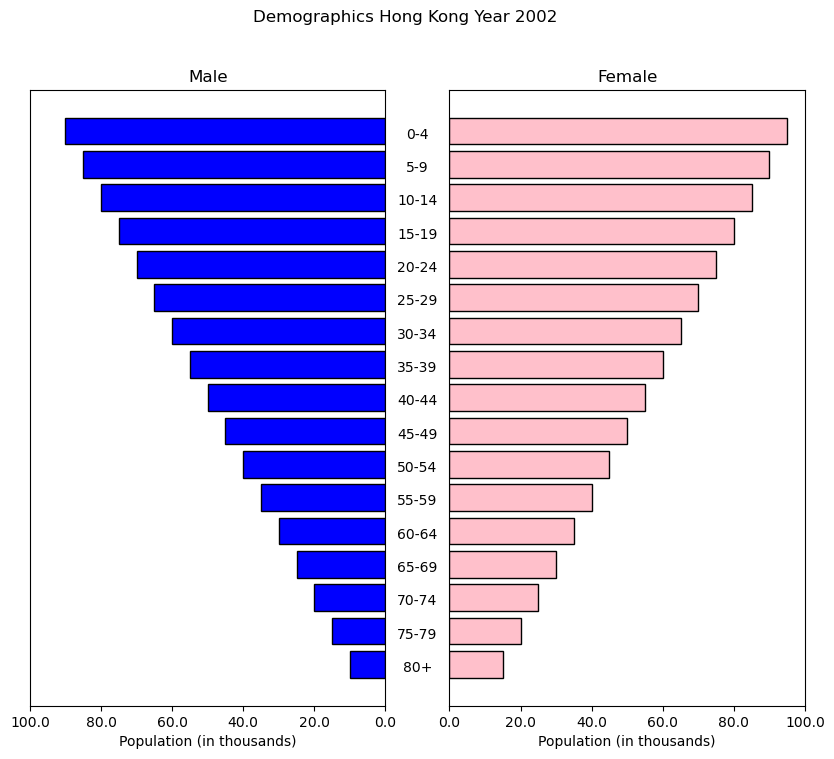

In [48]:
import matplotlib.pyplot as plt
import pandas as pd

# Create sample data
data = {
    'Age_Group': ['80+', '75-79', '70-74', '65-69', '60-64', '55-59', '50-54', '45-49', '40-44', '35-39', '30-34', '25-29', '20-24', '15-19', '10-14', '5-9', '0-4'],
    'Male': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90],
    'Female': [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
}

df = pd.DataFrame(data)

# Create the subplots with a shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8), sharey=True)

# Plot the 'Male' bars on the left subplot
ax1.barh(df['Age_Group'], df['Male'], color='blue', edgecolor='black')
ax1.set(title='Male')
# Fix the tick labels without warnings
ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels([str(abs(tick)) for tick in ax1.get_xticks()])

# Plot the 'Female' bars on the right subplot
ax2.barh(df['Age_Group'], df['Female'], color='pink', edgecolor='black')
ax2.set(title='Female')
# Fix the tick labels without warnings
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels([str(abs(tick)) for tick in ax2.get_xticks()])

# Invert the x-axis of the left subplot to have negative values
ax1.invert_xaxis()

# Set the y-axis label in the middle
fig.subplots_adjust(wspace=0.18)  # Adjust the spacing between the two subplots
fig.suptitle('Demographics Hong Kong Year 2002')

# Remove grid lines
ax1.grid(False)
ax2.grid(False)

# Set the labels for each subplot
ax1.set_xlabel('Population (in thousands)')
ax2.set_xlabel('Population (in thousands)')

# Hide the original y-axis labels for both subplots
ax1.yaxis.set_visible(False)
ax2.yaxis.set_visible(False)

# Determine the vertical position for each age group label
# The y-coordinate can be calculated as the index plus the bar width divided by 2 to center the label
bar_width = 0.8  # This should be the same as the bar width used in barh, which defaults to 0.8
x_offset = -9
y_offset = -0.5
for i, age_group in enumerate(df['Age_Group']):
    y_coordinate = i + bar_width / 2 + offset
    fig.text(x_offset, y_coordinate, age_group, ha='center', va='center', transform=ax1.transData)


# Show the plot
plt.show()


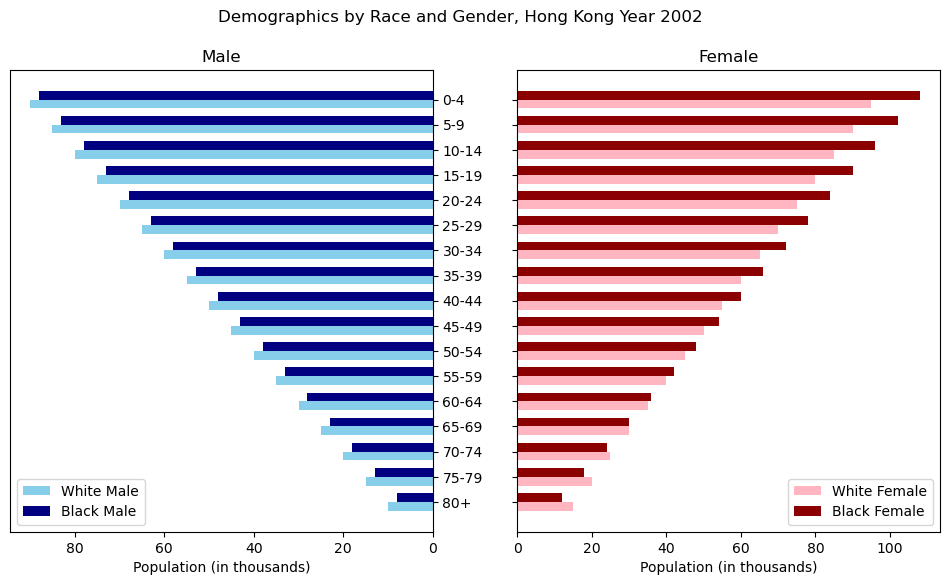

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Updated data with two categories for each gender
data = {
  'Age_Group': ['80+', '75-79', '70-74', '65-69', '60-64', '55-59', '50-54', '45-49', '40-44', '35-39', '30-34', '25-29', '20-24', '15-19', '10-14', '5-9', '0-4'],
  'White Male': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90],
  'Black Male': [8, 13, 18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68, 73, 78, 83, 88],
  'White Female': [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95],
  'Black Female': [12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108]
}

df = pd.DataFrame(data)

# Create the subplots with a shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Set the positions of the bars on the x-axis
indices = np.arange(len(df['Age_Group']))
width = 0.35 # the width of the bars

# Plot bars for males
ax1.barh(indices - width/2, df['White Male'], width, label='White Male', color='skyblue')
ax1.barh(indices + width/2, df['Black Male'], width, label='Black Male', color='navy')

# Plot bars for females
ax2.barh(indices - width/2, df['White Female'], width, label='White Female', color='lightpink')
ax2.barh(indices + width/2, df['Black Female'], width, label='Black Female', color='darkred')

# Invert the x-axis of the male subplot to have negative values
ax1.invert_xaxis()
ax1.yaxis.tick_right()

# Set titles
ax1.set(title='Male')
ax2.set(title='Female')

# Set y-ticks to be in the middle of the grouped bars
ax2.set_yticks(indices)
ax2.set_yticklabels(df['Age_Group'])

# Set x-axis labels
ax1.set_xlabel('Population (in thousands)')
ax2.set_xlabel('Population (in thousands)')

# Add legends
ax1.legend()
ax2.legend()

# Adjust layout
plt.subplots_adjust(wspace=0.2) # Adjust the spacing between the two subplots

# Set the figure title
fig.suptitle('Demographics by Race and Gender, Hong Kong Year 2002')

# Show the plot
plt.show()

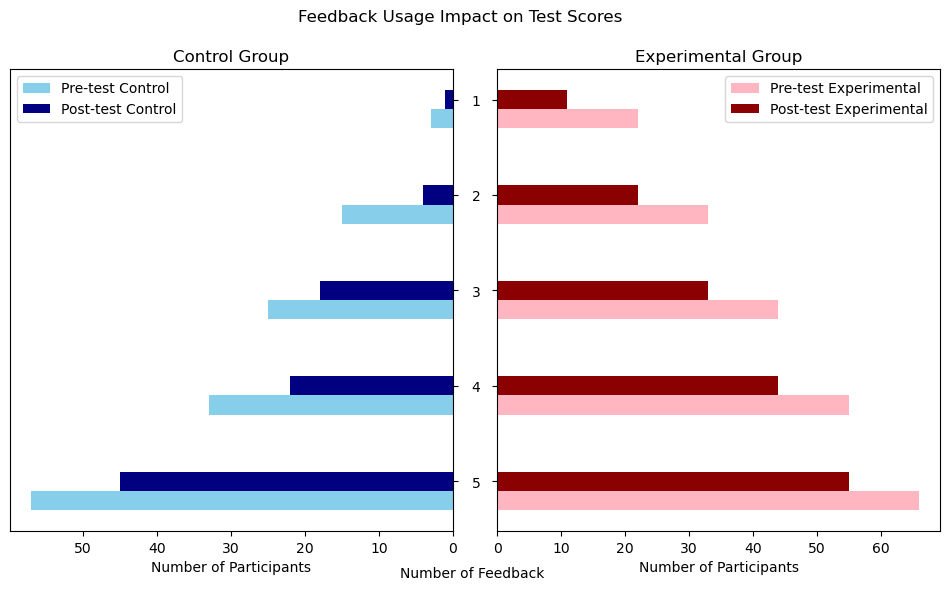

In [77]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# New data
data = {
    'Feedback Used': ['5', '4', '3', '2', '1'],  # Assuming these are feedback levels, with 1 being the highest
    'Pre-test Control': [57, 33, 25, 15, 3],
    'Post-test Control': [45, 22, 18, 4, 1],
    'Pre-test Experimental': [66, 55, 44, 33, 22],
    'Post-test Experimental': [55, 44, 33, 22, 11]
}

df = pd.DataFrame(data)

# Create the subplots with a shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Set the positions of the bars on the x-axis
indices = np.arange(len(df['Feedback Used']))
width = 0.2  # the width of the bars has been adjusted to accommodate four bars

# Plot bars for Control group
ax1.barh(indices - width, df['Pre-test Control'], width, label='Pre-test Control', color='skyblue')
ax1.barh(indices, df['Post-test Control'], width, label='Post-test Control', color='navy')

# Plot bars for Experimental group
ax2.barh(indices - width, df['Pre-test Experimental'], width, label='Pre-test Experimental', color='lightpink')
ax2.barh(indices, df['Post-test Experimental'], width, label='Post-test Experimental', color='darkred')

# Invert the x-axis of the Control subplot for a mirrored effect
ax1.invert_xaxis()
ax1.yaxis.tick_right()
ax1.tick_params(axis='y', which='major', pad=10)

# Set titles
ax1.set(title='Control Group')
ax2.set(title='Experimental Group')

# Set y-ticks to be in the middle of the grouped bars
ax2.set_yticks(indices)
ax2.set_yticklabels(df['Feedback Used'])

# Set y-axis label as text
fig.text(0.51, 0.04, 'Number of Feedback', ha='center', va='center')


# Set x-axis labels
ax1.set_xlabel('Number of Participants')
ax2.set_xlabel('Number of Participants')

# Add legends
ax1.legend()
ax2.legend()

# Adjust layout
plt.subplots_adjust(wspace=0.1)  # Adjust the spacing between the two subplots to prevent overlap

# Set the figure title
fig.suptitle('Feedback Usage Impact on Test Scores')

# Show the plot
plt.show()
